In [27]:
# xarray to read NETCDF
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# Set index to be reindex to
new_lat = np.arange(-90, 90, 0.5)
new_lon = np.arange(-180, 180, 0.5)

# Opening all netCDF files
CanESM5 = xr.open_mfdataset('data/NMME/CanESM5/*.nc')
CanESM5 = CanESM5.assign_coords(X=(((CanESM5.X + 180) % 360) - 180)).sortby(['X'])
CanESM5 = CanESM5.reindex(X=new_lon, Y=new_lat).ffill('X').ffill('Y')

chirps = xr.open_dataset('data/CHIRPS/chirps-v2.0.monthly.nc')

In [29]:
# Subset the South Sudan Region CanESM5
CanESM5_south_sudan = (CanESM5.sel(Y=slice(3.5, 12.5), X=slice(25, 35))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_south_sudan = chirps.sel(latitude=slice(3,13), longitude=slice(24.5,35.5)).interp_like(CanESM5_south_sudan, method='nearest')

# Calculate realized dates for CanESM5
CanESM5_south_sudan_df = CanESM5_south_sudan.to_dataframe().reset_index()
CanESM5_south_sudan_df['realization time'] = CanESM5_south_sudan_df['date of prediction'] + (CanESM5_south_sudan_df['lead time'] * 30).astype('timedelta64[D]')
CanESM5_south_sudan_df['month'] = CanESM5_south_sudan_df['realization time'].dt.month
CanESM5_south_sudan_df['year'] = CanESM5_south_sudan_df['realization time'].dt.year

# Convert CHIRPS to dataframe
chirps_south_sudan_df = chirps_south_sudan.to_dataframe().reset_index()
chirps_south_sudan_df['month'] = chirps_south_sudan_df['time'].dt.month
chirps_south_sudan_df['year'] = chirps_south_sudan_df['time'].dt.year

# Merge CHIRPS and CanESM5 dataframe
south_sudan_merged_df = CanESM5_south_sudan_df.merge(chirps_south_sudan_df, how='left', left_on=['month', 'year', 'latitude', 'longitude'], right_on=['month', 'year', 'latitude', 'longitude']).dropna()

# Save to .csv
south_sudan_merged_df.to_csv('data/csv/south_sudan_CanESM5_merged.csv')

south_sudan_merged_df = south_sudan_merged_df.drop(['realization time', 'date of prediction', 'latitude', 'longitude', 'year', 'time'], axis=1)

# Make calculations on the merged dataframe for plotting
corr_clean = south_sudan_merged_df.groupby(['month', 'lead time', 'M']).corr(method='spearman').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_south_sudan = south_sudan_merged_df.groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index()
stat_south_sudan.columns = stat_south_sudan.columns.droplevel()
stat_south_sudan.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_south_sudan_clean = stat_south_sudan.merge(corr_clean_1.reset_index(), on = ['month', 'lead time', 'M'], how = 'left').drop("index", axis = 1)
stat_south_sudan_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_south_sudan_clean['conditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_south_sudan_clean['unconditional bias'] = stat_south_sudan_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_south_sudan_clean['potential skill'] = stat_south_sudan_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.drop(['pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_south_sudan_clean['skill score'] = stat_south_sudan_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_south_sudan_clean = stat_south_sudan_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_south_sudan_clean['region'] = 'South Sudan'

In [30]:
# Subset the Eastern East Africa Region CanESM5
CanESM5_eastern_east_africa = (CanESM5.sel(Y=slice(-3.5, 8), X=slice(38, 50))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of CanESM5
chirps_eastern_east_africa = chirps.sel(latitude=slice(-4, 8.5), longitude=slice(37.5, 50.5)).interp_like(CanESM5_eastern_east_africa, method='nearest')

# Calculate realized dates for CanESM5
CanESM5_eastern_east_africa_df = CanESM5_eastern_east_africa.to_dataframe().reset_index()
CanESM5_eastern_east_africa_df['realization time'] = CanESM5_eastern_east_africa_df['date of prediction'] + (CanESM5_eastern_east_africa_df['lead time'] * 30).astype('timedelta64[D]')
CanESM5_eastern_east_africa_df['month'] = CanESM5_eastern_east_africa_df['realization time'].dt.month
CanESM5_eastern_east_africa_df['year'] = CanESM5_eastern_east_africa_df['realization time'].dt.year

# Convert CHIRPS to dataframe
chirps_eastern_east_africa_df = chirps_eastern_east_africa.to_dataframe().reset_index()
chirps_eastern_east_africa_df['month'] = chirps_eastern_east_africa_df['time'].dt.month
chirps_eastern_east_africa_df['year'] = chirps_eastern_east_africa_df['time'].dt.year

# Merge CHIRPS and CanESM5 dataframe
eastern_east_africa_merged_df = CanESM5_eastern_east_africa_df.merge(chirps_eastern_east_africa_df, how='left', left_on=['month', 'year', 'latitude', 'longitude'], right_on=['month', 'year', 'latitude', 'longitude']).dropna()

# Save to .csv
eastern_east_africa_merged_df.to_csv('data/csv/eastern_east_africa_CanESM5_merged.csv')

eastern_east_africa_merged_df = eastern_east_africa_merged_df.drop(['realization time', 'date of prediction', 'latitude', 'longitude', 'year', 'time'], axis=1)

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_east_africa_merged_df.groupby(['month', 'lead time', 'M']).corr(method='spearman').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_east_africa = eastern_east_africa_merged_df.groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index()
stat_eastern_east_africa.columns = stat_eastern_east_africa.columns.droplevel()
stat_eastern_east_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_east_africa_clean = stat_eastern_east_africa.merge(corr_clean_1.reset_index(), on = ['month', 'lead time', 'M'], how = 'left').drop("index", axis = 1)
stat_eastern_east_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_eastern_east_africa_clean['conditional bias'] = stat_eastern_east_africa_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_eastern_east_africa_clean['unconditional bias'] = stat_eastern_east_africa_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_eastern_east_africa_clean['potential skill'] = stat_eastern_east_africa_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.drop(['pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_eastern_east_africa_clean['skill score'] = stat_eastern_east_africa_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_eastern_east_africa_clean = stat_eastern_east_africa_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_eastern_east_africa_clean['region'] = 'Eastern East Africa'

In [31]:
# Subset the Eastern Ukraine Region CanESM5
CanESM5_eastern_ukraine = (CanESM5.sel(Y=slice(45, 51), X=slice(31, 40))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_eastern_ukraine = chirps.sel(latitude=slice(44.5, 51.5), longitude=slice(30.5, 40.5)).interp_like(CanESM5_eastern_ukraine, method='nearest')

# Calculate realized dates for CanESM5
CanESM5_eastern_ukraine_df = CanESM5_eastern_ukraine.to_dataframe().reset_index()
CanESM5_eastern_ukraine_df['realization time'] = CanESM5_eastern_ukraine_df['date of prediction'] + (CanESM5_eastern_ukraine_df['lead time'] * 30).astype('timedelta64[D]')
CanESM5_eastern_ukraine_df['month'] = CanESM5_eastern_ukraine_df['realization time'].dt.month
CanESM5_eastern_ukraine_df['year'] = CanESM5_eastern_ukraine_df['realization time'].dt.year

# Convert CHIRPS to dataframe
chirps_eastern_ukraine_df = chirps_eastern_ukraine.to_dataframe().reset_index()
chirps_eastern_ukraine_df['month'] = chirps_eastern_ukraine_df['time'].dt.month
chirps_eastern_ukraine_df['year'] = chirps_eastern_ukraine_df['time'].dt.year

# Merge CHIRPS and CanESM5 dataframe
eastern_ukraine_merged_df = CanESM5_eastern_ukraine_df.merge(chirps_eastern_ukraine_df, how='left', left_on=['month', 'year', 'latitude', 'longitude'], right_on=['month', 'year', 'latitude', 'longitude']).dropna()

# Save to .csv
eastern_ukraine_merged_df.to_csv('data/csv/eastern_ukraine_CanESM5_merged.csv')

eastern_ukraine_merged_df = eastern_ukraine_merged_df.drop(['realization time', 'date of prediction', 'latitude', 'longitude', 'year', 'time'], axis=1)

# Make calculations on the merged dataframe for plotting
corr_clean = eastern_ukraine_merged_df.groupby(['month', 'lead time', 'M']).corr(method='spearman').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_eastern_ukraine = eastern_ukraine_merged_df.groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index()
stat_eastern_ukraine.columns = stat_eastern_ukraine.columns.droplevel()
stat_eastern_ukraine.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_eastern_ukraine_clean = stat_eastern_ukraine.merge(corr_clean_1.reset_index(), on = ['month', 'lead time', 'M'], how = 'left').drop("index", axis = 1)
stat_eastern_ukraine_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_eastern_ukraine_clean['conditional bias'] = stat_eastern_ukraine_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_eastern_ukraine_clean['unconditional bias'] = stat_eastern_ukraine_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_eastern_ukraine_clean['potential skill'] = stat_eastern_ukraine_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.drop(['pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_eastern_ukraine_clean['skill score'] = stat_eastern_ukraine_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_eastern_ukraine_clean = stat_eastern_ukraine_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_eastern_ukraine_clean['region'] = 'Eastern Ukraine'

In [32]:
# Subset the Southern Africa Region CanESM5
CanESM5_southern_africa = (CanESM5.sel(Y=slice(-23, -15), X=slice(25, 34))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_southern_africa = chirps.sel(latitude=slice(-24.5, -14.5), longitude=slice(24.5, 34.5)).interp_like(CanESM5_southern_africa, method='nearest')

# Calculate realized dates for CanESM5
CanESM5_southern_africa_df = CanESM5_southern_africa.to_dataframe().reset_index()
CanESM5_southern_africa_df['realization time'] = CanESM5_southern_africa_df['date of prediction'] + (CanESM5_southern_africa_df['lead time'] * 30).astype('timedelta64[D]')
CanESM5_southern_africa_df['month'] = CanESM5_southern_africa_df['realization time'].dt.month
CanESM5_southern_africa_df['year'] = CanESM5_southern_africa_df['realization time'].dt.year

# Convert CHIRPS to dataframe
chirps_southern_africa_df = chirps_southern_africa.to_dataframe().reset_index()
chirps_southern_africa_df['month'] = chirps_southern_africa_df['time'].dt.month
chirps_southern_africa_df['year'] = chirps_southern_africa_df['time'].dt.year

# Merge CHIRPS and CanESM5 dataframe
southern_africa_merged_df = CanESM5_southern_africa_df.merge(chirps_southern_africa_df, how='left', left_on=['month', 'year', 'latitude', 'longitude'], right_on=['month', 'year', 'latitude', 'longitude']).dropna()

# Save to .csv
southern_africa_merged_df.to_csv('data/csv/southern_africa_CanESM5_merged.csv')

southern_africa_merged_df = southern_africa_merged_df.drop(['realization time', 'date of prediction', 'latitude', 'longitude', 'year', 'time'], axis=1)

# Make calculations on the merged dataframe for plotting
corr_clean = southern_africa_merged_df.groupby(['month', 'lead time', 'M']).corr(method='spearman').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_southern_africa = southern_africa_merged_df.groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index()
stat_southern_africa.columns = stat_southern_africa.columns.droplevel()
stat_southern_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_southern_africa_clean = stat_southern_africa.merge(corr_clean_1.reset_index(), on = ['month', 'lead time', 'M'], how = 'left').drop("index", axis = 1)
stat_southern_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_southern_africa_clean['conditional bias'] = stat_southern_africa_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_southern_africa_clean['unconditional bias'] = stat_southern_africa_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_southern_africa_clean['potential skill'] = stat_southern_africa_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_southern_africa_clean = stat_southern_africa_clean.drop(['pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_southern_africa_clean['skill score'] = stat_southern_africa_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_southern_africa_clean = stat_southern_africa_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_southern_africa_clean['region'] = 'Southern Africa'

In [33]:
# Subset the West Africa Region CanESM5
CanESM5_west_africa = (CanESM5.sel(Y=slice(10, 13.5), X=slice(-10, 0))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_west_africa = (chirps.sel(latitude=slice(9.5, 14), longitude=slice(-10.5, 0.5)) # One degree of resolution must be added for interpolation
                    .interp_like(CanESM5_west_africa, method='nearest'))

# Calculate realized dates for CanESM5
CanESM5_west_africa_df = CanESM5_west_africa.to_dataframe().reset_index()
CanESM5_west_africa_df['realization time'] = CanESM5_west_africa_df['date of prediction'] + (CanESM5_west_africa_df['lead time'] * 30).astype('timedelta64[D]')
CanESM5_west_africa_df['month'] = CanESM5_west_africa_df['realization time'].dt.month
CanESM5_west_africa_df['year'] = CanESM5_west_africa_df['realization time'].dt.year

# Convert CHIRPS to dataframe
chirps_west_africa_df = chirps_west_africa.to_dataframe().reset_index()
chirps_west_africa_df['month'] = chirps_west_africa_df['time'].dt.month
chirps_west_africa_df['year'] = chirps_west_africa_df['time'].dt.year

# Merge CHIRPS and CanESM5 dataframe
west_africa_merged_df = CanESM5_west_africa_df.merge(chirps_west_africa_df, how='left', left_on=['month', 'year', 'latitude', 'longitude'], right_on=['month', 'year', 'latitude', 'longitude']).dropna()

# Save to .csv
west_africa_merged_df.to_csv('data/csv/west_africa_CanESM5_merged.csv')

west_africa_merged_df = west_africa_merged_df.drop(['realization time', 'date of prediction', 'latitude', 'longitude', 'year', 'time'], axis=1)

# Make calculations on the merged dataframe for plotting
corr_clean = west_africa_merged_df.groupby(['month', 'lead time', 'M']).corr(method='spearman').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_west_africa = west_africa_merged_df.groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index()
stat_west_africa.columns = stat_west_africa.columns.droplevel()
stat_west_africa.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_west_africa_clean = stat_west_africa.merge(corr_clean_1.reset_index(), on = ['month', 'lead time', 'M'], how = 'left').drop("index", axis = 1)
stat_west_africa_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_west_africa_clean['conditional bias'] = stat_west_africa_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_west_africa_clean['unconditional bias'] = stat_west_africa_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_west_africa_clean['potential skill'] = stat_west_africa_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_west_africa_clean = stat_west_africa_clean.drop(['pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_west_africa_clean['skill score'] = stat_west_africa_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_west_africa_clean = stat_west_africa_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_west_africa_clean['region'] = 'West Africa'

In [34]:
# Subset the Sri Lanka Region CanESM5
CanESM5_sri_lanka = (CanESM5.sel(Y=slice(5.5, 10), X=slice(79.5, 82))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_sri_lanka = (chirps.sel(latitude=slice(5, 10.5), longitude=slice(79, 82.5)) # One degree of resolution must be added for interpolation
                    .interp_like(CanESM5_sri_lanka, method='nearest'))

# Calculate realized dates for CanESM5
CanESM5_sri_lanka_df = CanESM5_sri_lanka.to_dataframe().reset_index()
CanESM5_sri_lanka_df['realization time'] = CanESM5_sri_lanka_df['date of prediction'] + (CanESM5_sri_lanka_df['lead time'] * 30).astype('timedelta64[D]')
CanESM5_sri_lanka_df['month'] = CanESM5_sri_lanka_df['realization time'].dt.month
CanESM5_sri_lanka_df['year'] = CanESM5_sri_lanka_df['realization time'].dt.year

# Convert CHIRPS to dataframe
chirps_sri_lanka_df = chirps_sri_lanka.to_dataframe().reset_index()
chirps_sri_lanka_df['month'] = chirps_sri_lanka_df['time'].dt.month
chirps_sri_lanka_df['year'] = chirps_sri_lanka_df['time'].dt.year

# Merge CHIRPS and CanESM5 dataframe
sri_lanka_merged_df = CanESM5_sri_lanka_df.merge(chirps_sri_lanka_df, how='left', left_on=['month', 'year', 'latitude', 'longitude'], right_on=['month', 'year', 'latitude', 'longitude']).dropna()

# Save to .csv
sri_lanka_merged_df.to_csv('data/csv/sri_lanka_CanESM5_merged.csv')

sri_lanka_merged_df = sri_lanka_merged_df.drop(['realization time', 'date of prediction', 'latitude', 'longitude', 'year', 'time'], axis=1)

# Make calculations on the merged dataframe for plotting
corr_clean = sri_lanka_merged_df.groupby(['month', 'lead time', 'M']).corr(method='spearman').drop('precip', axis = 1).droplevel(level=3).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])

stat_sri_lanka = sri_lanka_merged_df.groupby(['month', 'lead time', 'M']).agg(['mean', 'std']).reset_index()
stat_sri_lanka.columns = stat_sri_lanka.columns.droplevel()
stat_sri_lanka.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_sri_lanka_clean = stat_sri_lanka.merge(corr_clean_1.reset_index(), on = ['month', 'lead time', 'M'], how = 'left').drop("index", axis = 1)
stat_sri_lanka_clean.columns = ['month', 'lead time', 'M', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_sri_lanka_clean['conditional bias'] = stat_sri_lanka_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_sri_lanka_clean['unconditional bias'] = stat_sri_lanka_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_sri_lanka_clean['potential skill'] = stat_sri_lanka_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_sri_lanka_clean = stat_sri_lanka_clean.drop(['pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_sri_lanka_clean['skill score'] = stat_sri_lanka_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_sri_lanka_clean = stat_sri_lanka_clean.groupby(['month', 'lead time']).mean().drop('M', axis=1).reset_index()
stat_sri_lanka_clean['region'] = 'Sri Lanka'

In [35]:
df_list = [stat_south_sudan_clean, stat_sri_lanka_clean, stat_eastern_east_africa_clean, stat_eastern_ukraine_clean, stat_west_africa_clean, stat_southern_africa_clean]
CanESM5_stat_final = pd.concat(df_list)
CanESM5_stat_final

,month,lead time,corr,conditional bias,unconditional bias,potential skill,skill score,region
0,1,0.5,0.737610,0.455652,0.225393,0.544128,-0.136916,South Sudan
1,1,1.5,0.724988,0.448035,0.224592,0.525979,-0.146649,South Sudan
2,1,2.5,0.718191,0.449270,0.229487,0.516180,-0.162578,South Sudan
3,1,3.5,0.716647,0.447144,0.230541,0.513936,-0.163750,South Sudan
4,1,4.5,0.718295,0.449885,0.231226,0.516154,-0.164957,South Sudan
...,...,...,...,...,...,...,...,...
139,12,7.5,0.237985,0.042910,3.071044,0.061630,-3.052324,Southern Africa
140,12,8.5,0.239160,0.049086,3.074399,0.067114,-3.056371,Southern Africa
141,12,9.5,0.230083,0.044794,3.076620,0.062011,-3.059403,Southern Africa
142,12,10.5,0.249891,0.046108,3.077235,0.065599,-3.057744,Southern Africa


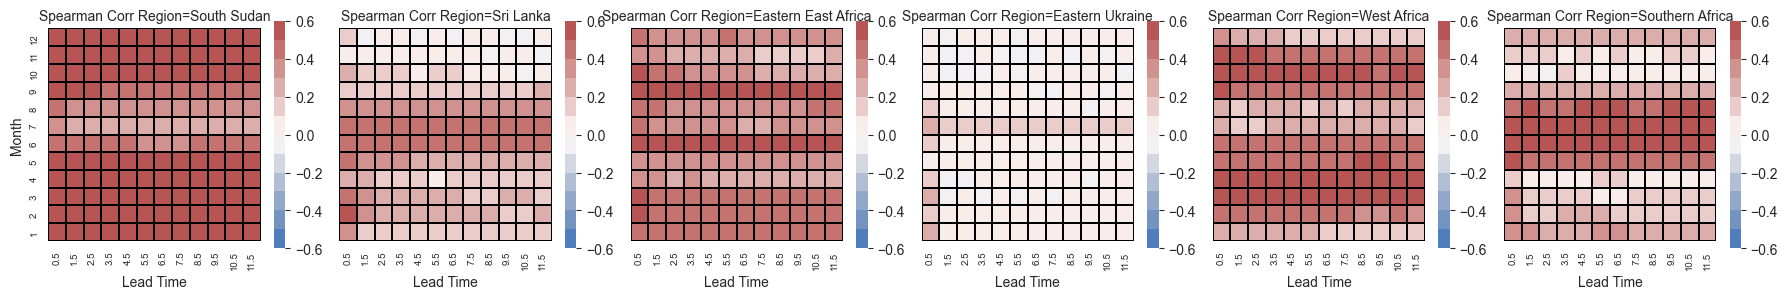

In [43]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs, vmin=-0.6, vmax=0.6, 
                cmap=sns.color_palette('vlag', 12),
                linewidths=0.1, linecolor='black')
    plt.xticks(np.arange(0.5, 12.5, 1))  # Set xticks explicitly
    plt.gca().set_xticklabels(np.arange(0.5, 12.5, 1))  # Set xticklabels
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.gca().invert_yaxis()

fg = sns.FacetGrid(CanESM5_stat_final, col='region')
fg.map_dataframe(draw_heatmap, 'lead time', 'month', 'corr', square = True)

fg.set_titles('Spearman Corr Region={col_name}')
fg.set_ylabels("Month")
fg.set_xlabels("Lead Time")
plt.show()
fg.savefig('figures/CanESM5_corr.png')

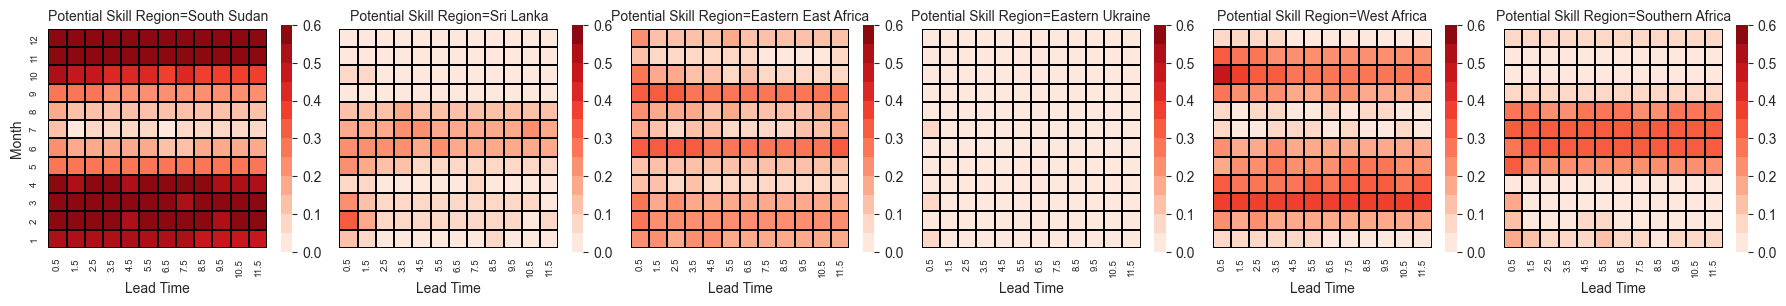

In [36]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs, vmin=0, vmax=0.6, 
                cmap=sns.color_palette('Reds', 12),
                linewidths=0.1, linecolor='black')
    plt.xticks(np.arange(0.5, 12.5, 1))  # Set xticks explicitly
    plt.gca().set_xticklabels(np.arange(0.5, 12.5, 1))  # Set xticklabels
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.gca().invert_yaxis()

fg = sns.FacetGrid(CanESM5_stat_final, col='region')
fg.map_dataframe(draw_heatmap, 'lead time', 'month', 'potential skill', square = True)

fg.set_titles('Potential Skill Region={col_name}')
fg.set_ylabels("Month")
fg.set_xlabels("Lead Time")
plt.show()
fg.savefig('figures/CanESM5_potential_skill.png')

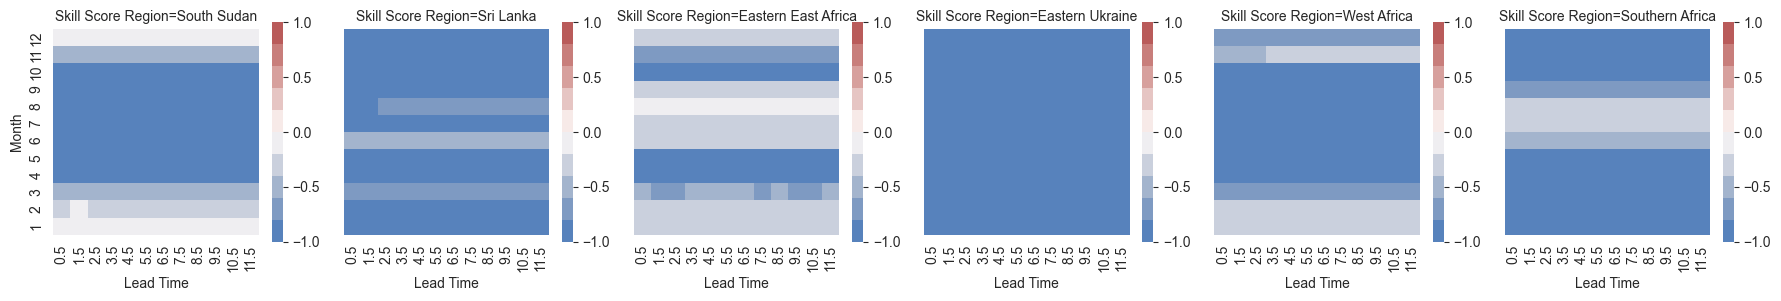

In [37]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs, vmin=-1, vmax=1, cmap=sns.color_palette('vlag', 10))
    plt.gca().invert_yaxis()

fg = sns.FacetGrid(CanESM5_stat_final, col='region')
fg.map_dataframe(draw_heatmap, 'lead time', 'month', 'skill score', square = True)

fg.set_titles('Skill Score Region={col_name}')
fg.set_ylabels("Month")
fg.set_xlabels("Lead Time")
plt.show()
fg.savefig('figures/CanESM5_skill_score.png')

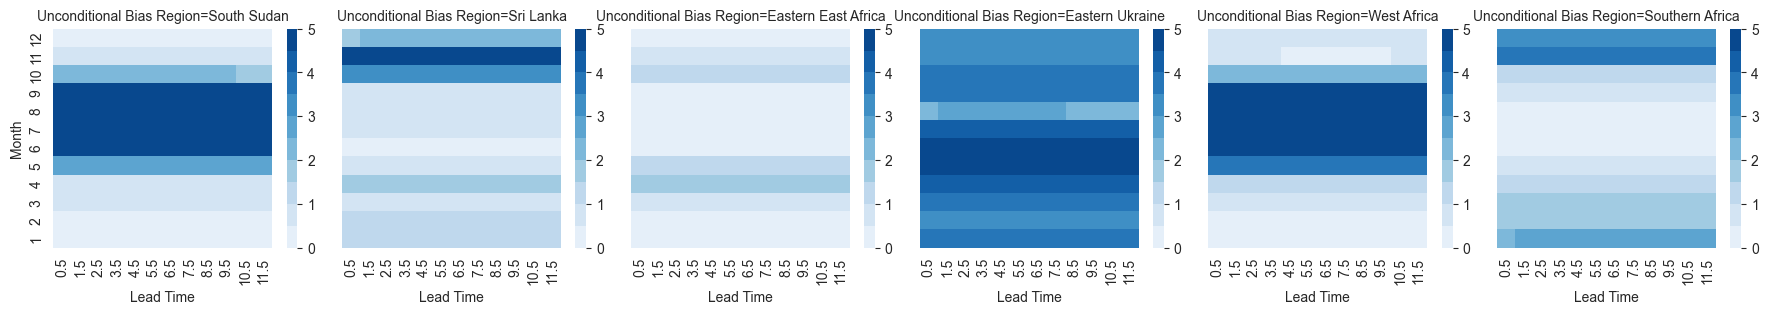

In [38]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs, vmin=0, vmax=5, cmap=sns.color_palette('Blues', 10))
    plt.gca().invert_yaxis()

fg = sns.FacetGrid(CanESM5_stat_final, col='region')
fg.map_dataframe(draw_heatmap, 'lead time', 'month', 'unconditional bias', square = True)

fg.set_titles('Unconditional Bias Region={col_name}')
fg.set_ylabels("Month")
fg.set_xlabels("Lead Time")
plt.show()
fg.savefig('figures/CanESM5_unconditional_bias.png')

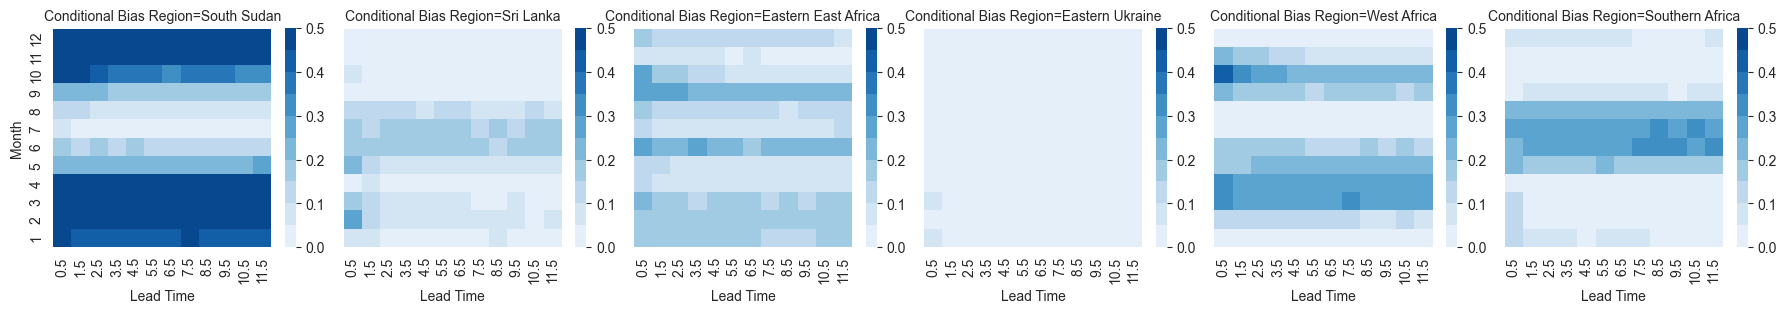

In [39]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs, vmin=0, vmax=0.5, cmap=sns.color_palette('Blues', 10))
    plt.gca().invert_yaxis()

fg = sns.FacetGrid(CanESM5_stat_final, col='region')
fg.map_dataframe(draw_heatmap, 'lead time', 'month', 'conditional bias', square = True)

fg.set_titles('Conditional Bias Region={col_name}')
fg.set_ylabels("Month")
fg.set_xlabels("Lead Time")
plt.show()
fg.savefig('figures/CanESM5_conditional_bias.png')